## Dataset creation

In [1]:
# Setting current working directory
import os
os.chdir('C:/Users/ivanb/Documents/GitHub/ML Project 2')
print(os.getcwd())

C:\Users\ivanb\Documents\GitHub\ML Project 2


In [2]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageOps
from pdf2image import convert_from_path
from img2pdf import convert
from skimage import color
import pickle

### Definition of conversion functions

In [3]:
def masks_convert(folder, verbose = False):
    """ Convert masks from pdf format to npy format with one channel"""
    input_directory = os.path.join(os.getcwd(), folder, 'masks_old')
    directory = os.path.join(os.getcwd(), folder, 'masks')
    os.makedirs(directory, exist_ok=True)
    k = 1
    for fname in os.listdir(input_directory):
        
        # Setting the input and the output path
        fpath = os.path.join(input_directory, fname)
        out_fname = fname.rsplit('.', 1)[0] + '.npy'
        out_fpath = os.path.join(directory, out_fname)
        
        # Reading the image from pdf
        if fname.endswith('.pdf'):
            if verbose == True:
                print('Converting mask: ', k)
                k = k+1
            pages = convert_from_path(fpath)
            assert len(pages) == 1
            image = pages[0]
            #print(np.array(image).shape())
            (_, image) = cv2.threshold(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
            #print(image.shape)
            assert((np.unique(image) == [0, 255]).all())

            np.save(out_fpath, image)

In [4]:
def images_convert(folder, verbose = False):
    """ Converts the images to numpy ndarrays"""
    input_directory = os.path.join(os.getcwd(), folder, 'images_old')
    directory = os.path.join(os.getcwd(), folder, 'images')
    os.makedirs(directory, exist_ok=True)
    k = 1
    for fname in os.listdir(input_directory):
        # Setting the input and the output path
        fpath = os.path.join(input_directory, fname)
        out_fname = fname.rsplit('.', 1)[0] + '.npy'
        out_fpath = os.path.join(directory, out_fname)
        
        if fname.endswith('.pdf') or fname.endswith('.tif'):
            if verbose == True:
                print('Converting image: ', k)
                k = k+1

            if fname.endswith('.pdf'):
                pages = convert_from_path(fpath)
                assert len(pages) == 1
                image = pages[0]
                image = np.array(image)

            if fname.endswith('.tif'):
                image = cv2.imread(fpath)
            
            np.save(out_fpath, image)

In [5]:
def resize_im_mask(folder, size = (160,160), verbose = False):
    """ Resizes the masks and the images together, renaming them with sequential names.
        If verbose = True it also displays the images and the masks overlaid
        Returns a dictionary with the original shapes.
    """
    input_mask_directory = os.path.join(os.getcwd(), folder, 'masks')
    input_img_directory = os.path.join(os.getcwd(), folder, 'images')
    os.makedirs(os.path.join(os.getcwd(), folder, 'definitive'), exist_ok=True)
    mask_directory = os.path.join(os.getcwd(), folder, 'definitive/masks')
    os.makedirs(mask_directory, exist_ok=True)
    img_directory = os.path.join(os.getcwd(), folder, 'definitive/images')
    os.makedirs(img_directory, exist_ok=True)

    # Creating dictionary to store the original shapes
    original_shapes = {}

    k = 0
    for fname in os.listdir(input_mask_directory):
        if fname.endswith('.npy'):
            k = k+1
            if verbose == True:
                print('Resizing image: ', k)
            # Setting the input and the output path
            mask_fpath = os.path.join(input_mask_directory, fname)
            img_fpath = os.path.join(input_img_directory, fname)
            out_mask_fpath = os.path.join(mask_directory, fname)
            out_img_fpath = os.path.join(img_directory, fname)
            # Uncomment the following lines to have sequential names
            # out_mask_fpath = os.path.join(mask_directory, str(k)+'.npy')
            # out_img_fpath = os.path.join(img_directory, str(k)+ '.npy')
            
        
            # Loading the image and the mask
            mask = np.load(mask_fpath)
            image = np.load(img_fpath)

            # Saving the original shapes in the dictionary
            mask_shape = mask.shape
            image_shape = image.shape
            original_shapes[fname] = {'mask': mask_shape, 'image': image_shape}
            
            # Resizing the image and the mask
            image_resized = cv2.resize(image, size)
            mask_resized_tmp = cv2.resize(mask, size)
            (_, mask_resized) = cv2.threshold(mask_resized_tmp, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            assert((np.unique(mask_resized) == [0, 255]).all())
            
            if verbose == True:
                # Plotting the images one over the other
                fig, axs = plt.subplots(1,3, figsize=(12, 12))
                axs[0].imshow(image_resized)
                axs[1].imshow(mask_resized)
                overlaying_image = color.label2rgb(mask_resized, image_resized, bg_label = 0)
                axs[2].imshow(overlaying_image)
                print(fname)
                plt.show()
                plt.pause(1)

            # Saving the image and the mask
            np.save(out_mask_fpath, mask_resized)
            print
            np.save(out_img_fpath, image_resized)

    # Saving the original shapes in a .pkl file
    pkl_path = os.path.join(os.getcwd(), folder, 'definitive/original_shapes.pkl')
    f = open(pkl_path,'wb')
    pickle.dump(original_shapes,f)
    f.close()
    
    return original_shapes

In [6]:
def rescale_to_01(folder, verbose = False, binary = False):
    """ Rescaling the values in the images and the masks from [0,255] to [0,1]"""
    directory = os.path.join(os.getcwd(), folder)
    out_directory = os.path.join(os.getcwd(), folder, 'rescaled')
    os.makedirs(out_directory, exist_ok=True)
    k = 0
    for fname in os.listdir(directory):
        if fname.endswith('.npy'):
            k = k+1
            if verbose == True:
                print('Rescaling element: ', k)
            
            # Setting the file path
            fpath = os.path.join(directory, fname)
            out_path = os.path.join(out_directory, fname)

            # Rescaling
            image = np.load(fpath)
            rescaled = image / 255
            if (binary == True):
                assert((np.unique(rescaled) == [0, 1]).all())
        
            if verbose == True:
                # Plotting the images to compare them
                fig, axs = plt.subplots(1,2, figsize=(12, 12))
                axs[0].imshow(image)
                axs[1].imshow(rescaled)
                print(fname)
                print(rescaled.max())
                plt.show()
                
            # Saving the image and the mask
            np.save(out_path, rescaled)

### Converting train data

In [130]:
# Relative path, it has to contain two folders: images_old and masks_old
rel_path = 'data/train_old'

# Converting masks from .pdf to .npy
#masks_convert(rel_path, False)

# Converting images from .pdf/.fig to .npy
#images_convert(rel_path, verbose = False)

# Resizing images from .pdf/.fig to .npy
downsampling_size = (160,160)
original_shapes = resize_im_mask(rel_path, size = downsampling_size, verbose = False)

# Rescaling the images from [0,255] to [0,1]
rescale_to_01(rel_path+'/definitive/images', verbose = False)
rescale_to_01(rel_path+'/definitive/masks', verbose = False, binary = True)

In [9]:
file_to_read = open("data/train_old/definitive/original_shapes.pkl", "rb")
loaded_dictionary = pickle.load(file_to_read)
# print(loaded_dictionary)

### Converting unlabelled data

In [10]:
def resize_im(folder, size = (160,160), verbose = False):
    """ Resizes the masks and the images together, renaming them with sequential names.
        Returns a dictionary with the original shapes.
    """
    input_img_directory = os.path.join(os.getcwd(), folder, 'images')
    os.makedirs(os.path.join(os.getcwd(), folder, 'definitive'), exist_ok=True)
    img_directory = os.path.join(os.getcwd(), folder, 'definitive/images')
    os.makedirs(img_directory, exist_ok=True)

    # Creating dictionary to store the original shapes
    original_shapes = {}

    k = 0
    for fname in os.listdir(input_img_directory):
        if fname.endswith('.npy'):
            k = k+1
            if verbose == True:
                print('Resizing image: ', k)
            # Setting the input and the output path
            img_fpath = os.path.join(input_img_directory, fname)
            out_img_fpath = os.path.join(img_directory, fname)
            
            # Loading the image and the mask
            image = np.load(img_fpath)

            # Saving the original shapes in the dictionary
            image_shape = image.shape
            original_shapes[fname] = {'image': image_shape}
            
            # Resizing the image and the mask
            image_resized = cv2.resize(image, size)
            
            # Saving the image and the mask
            np.save(out_img_fpath, image_resized)

    # Saving the original shapes in a .pkl file
    pkl_path = os.path.join(os.getcwd(), folder, 'definitive/original_shapes.pkl')
    f = open(pkl_path,'wb')
    pickle.dump(original_shapes,f)
    f.close()
    
    return original_shapes

In [12]:
# Relative path, it has to contain the folder images_old
#rel_path = 'data/originals/unlabelled'

# Converting images from .pdf/.fig to .npy
#images_convert(rel_path, verbose = True)

# Resizing images from .pdf/.fig to .npy
#original_shapes = resize_im(rel_path, size = downsampling_size, verbose = True)

# Rescaling the images from [0,255] to [0,1]
#rescale_to_01(rel_path+'/definitive/images', verbose = False)

##  Visualizing model predictions

In [13]:
import numpy as np
from tensorflow import keras
import math
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

from src.eval import get_model_prediction
import re

In [14]:
def output_predictions(imgpath,  trained_model=None, trained_model_checkpoint=None, show = True, maskpath = None, mask_comp = False, iou = False, regions = False, save = False):
    if trained_model is None and trained_model_checkpoint is None:
        raise ValueError('Must supply either model or model checkpoint file to output predictions.')

    if trained_model_checkpoint is not None:
        trained_model = keras.models.load_model(trained_model_checkpoint)

    img = np.load(imgpath)
    pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]

    if save:
        if mask_comp:
            fig_directory = os.path.join(os.getcwd(), 'figures/training_imgs')
        else:
            fig_directory = os.path.join(os.getcwd(), 'figures/unlabelled')
        os.makedirs(fig_directory, exist_ok=True)
        fname = imgpath.rsplit('\\', 1)[-1].rsplit('.', 1)[0]
        out_fname = os.path.join(fig_directory, fname)

    # Plotting the predictions over the image
    fig1, axs1 = plt.subplots(1,3, figsize=(12, 12))
    axs1[0].imshow(img)
    axs1[0].set_title('Original image')
    axs1[1].imshow(pred, cmap = 'gray', interpolation = 'none')
    axs1[1].set_title('Predicted fascicles')
    #overlaying_image = color.label2rgb(pred, img, bg_label = 0)
    #axs1[2].imshow(overlaying_image)
    axs1[2].imshow(img)
    axs1[2].imshow(pred, cmap = 'gray', alpha = 0.3,interpolation = 'none')
    axs1[2].set_title('Predicted fascicles overlaid \nonto the original image')
    if save:
        plt.savefig(out_fname + '_pred_over_img.jpg')
    if show:
        plt.show()

    # Plotting the predictions over the mask
    if mask_comp:
        mask = np.load(maskpath)
        fig2, axs2 = plt.subplots(1,3, figsize=(12, 12))
        axs2[0].imshow(mask, cmap = 'gray', interpolation = 'none')
        axs2[0].set_title('Mask')
        axs2[1].imshow(pred, cmap = 'viridis', interpolation = 'none')
        axs2[1].set_title('Predicted fascicles')
        axs2[2].imshow(mask, cmap = 'gray', interpolation = 'none')
        axs2[2].imshow(pred, cmap = 'viridis', alpha = 0.5,interpolation = 'none')
        
        metric = keras.metrics.MeanIoU(num_classes=2)
        metric.update_state(pred, mask)
        iou_score = np.round(metric.result().numpy(), decimals=2)
        
        axs2[2].set_title('Mask overlaid onto\npredicted fascicles\nIoU = ' + str(iou_score))
        if save:
            plt.savefig(out_fname + '_pred_over_mask.jpg')   
        if show:
            plt.show()

    # Regions
    if regions:
        reg_pred = label(((1 - pred) * 255).astype(int))
        fig3, axs3 = plt.subplots(1, 2, figsize=(8, 8))
        axs3[1].imshow(pred, cmap='gray', interpolation='none')
        regions_pred = regionprops(reg_pred)
        nreg_pred = len(regions_pred)
        for props in regions_pred:
            y0, x0 = props.centroid
            orientation = math.pi /2 - props.orientation
            theta = np.linspace(0, 2*math.pi, 100)
            x = x0 + 0.5 * props.major_axis_length * math.cos(orientation) * np.cos(theta) - 0.5 * props.minor_axis_length * math.sin(orientation) * np.sin(theta) 
            y = y0 + 0.5 * props.major_axis_length * math.sin(orientation) * np.cos(theta) + 0.5 * props.minor_axis_length * math.cos(orientation) * np.sin(theta)
            axs3[1].plot(x, y, '-r', linewidth=1)
        axs3[1].set_title('Regions predicted = ' + str(nreg_pred))
        
        
        if mask_comp:
            reg_mask = label(((1 - mask) * 255).astype(int))
            axs3[0].imshow(mask, cmap='gray', interpolation='none')
            regions_mask = regionprops(reg_mask)
            nreg_mask = len(regions_mask)
            for props in regions_mask:
                y0, x0 = props.centroid
                orientation = math.pi /2 - props.orientation
                theta = np.linspace(0, 2*math.pi, 100)
                x = x0 + 0.5 * props.major_axis_length * math.cos(orientation) * np.cos(theta) - 0.5 * props.minor_axis_length * math.sin(orientation) * np.sin(theta) 
                y = y0 + 0.5 * props.major_axis_length * math.sin(orientation) * np.cos(theta) + 0.5 * props.minor_axis_length * math.cos(orientation) * np.sin(theta)
                axs3[0].plot(x, y, '-r', linewidth=1)
            axs3[0].set_title('Regions mask = ' + str(nreg_mask))

        if save:
            plt.savefig(out_fname + '_regions.jpg')

        if show:
            plt.show()

                    
        

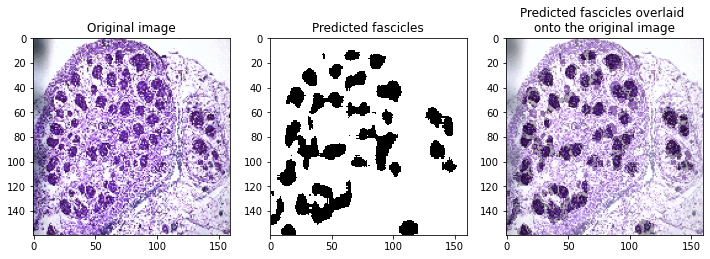

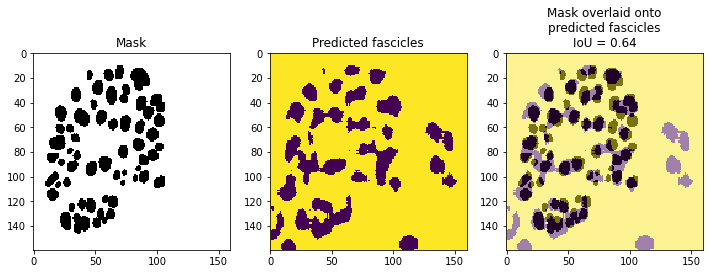

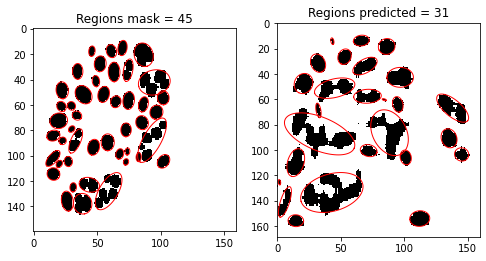

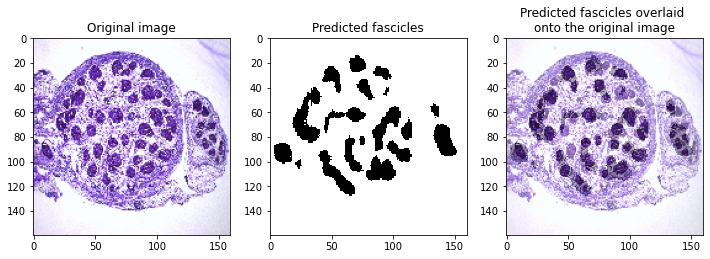

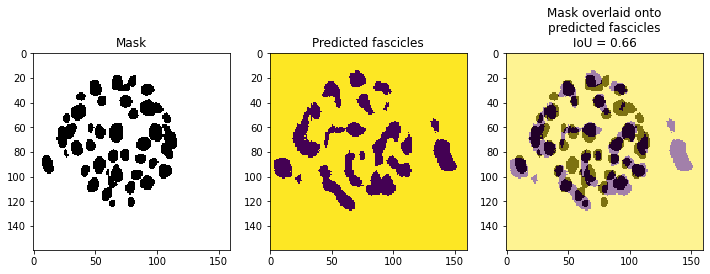

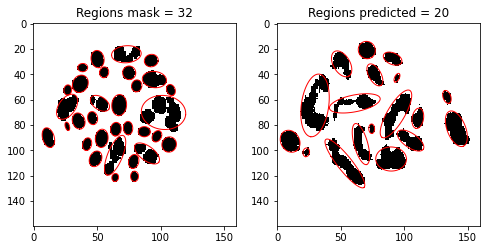

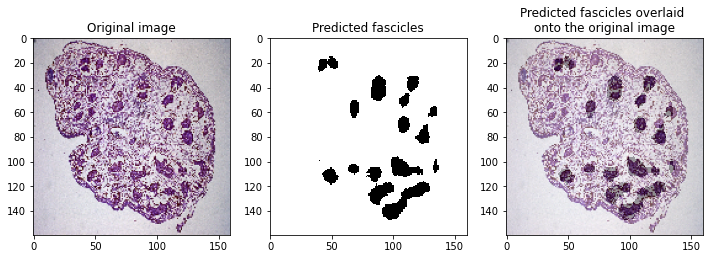

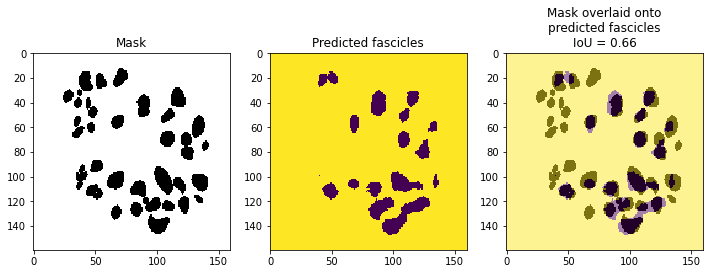

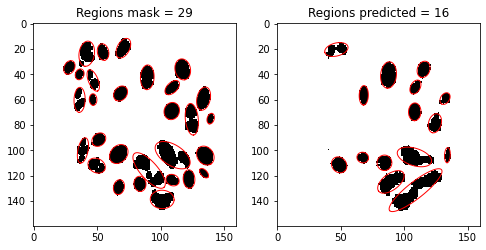

"\nimg_folder_unlabelled = 'data/520/unlabelled/images/rescaled'\nfnames_no_masks = ['Thoracic vagus nerve - Left - NeuHeart - 28.09.2020 - Slice n0002.npy',\n                   #'Thoracic vagus nerve - Right - NeuHeart - 28.09.2020 - second slide - Slice n0008.npy',\n                   #'Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0013.npy',\n                   #'Vago dx 06.11.18 - pezzo 1 - fetta centrale.npy',\n                   #'vago dx 25.07.18 - pezzo 3 - taglio a 4400.npy',\n                   #'vago dx 25.07.18 - pezzo 3 - taglio a 7000.npy',\n                   #'vago sx 24.10.18 - pezzo 2 - taglio a 6200.npy',\n                   #'vago sx 24.10.18 - pezzo 2 - taglio a 200.npy',\n                   #'vago DX  - 27.06.18 - HH - vetrino 1 - centrale - campione 0009.npy',\n                   #'vago DX  - 27.06.18 - HH - vetrino 1 - pezzo 3 - campione 0016.npy',\n                   #'vago DX - 25.07.18 - pezzo 1 - fetta 0017.npy',\n                   #'vago DX - 

In [40]:
#model_save_file = os.path.join(os.getcwd(), 'model_checkpoints/transforms512.h5')
#img_folder = 'data/520/train/images/rescaled'
#mask_folder = 'data/520/train/masks/rescaled'

model_save_file = os.path.join(os.getcwd(), 'model_checkpoints/Adam160_default.h5')
img_folder = 'data/training/160/images'
mask_folder = 'data/training/160/annotations'

fnames_masks = ['vago DX  - 27.06.18 - HH - vetrino 1 - centrale - campione 0010.npy',
                'vago DX  - 27.06.18 - HH - vetrino 1 - pezzo 3 - campione 0010.npy',
                'Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0055.npy',
                #'Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0160.npy',
                #'Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0215.npy',
                #'vago SX - 27.06.18 - pezzo 3 - fetta 0036.npy',
                #'vago SX - 27.06.18 - pezzo 4 - fetta 0015.npy'
                ]

for fname in fnames_masks:
    imgpath = os.path.join(os.getcwd(), img_folder, fname)
    maskpath = os.path.join(os.getcwd(), mask_folder, fname)
    output_predictions(imgpath, trained_model_checkpoint=model_save_file, maskpath = maskpath, mask_comp = True, regions = True, save = True)

'''
img_folder_unlabelled = 'data/520/unlabelled/images/rescaled'
fnames_no_masks = ['Thoracic vagus nerve - Left - NeuHeart - 28.09.2020 - Slice n0002.npy',
                   #'Thoracic vagus nerve - Right - NeuHeart - 28.09.2020 - second slide - Slice n0008.npy',
                   #'Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0013.npy',
                   #'Vago dx 06.11.18 - pezzo 1 - fetta centrale.npy',
                   #'vago dx 25.07.18 - pezzo 3 - taglio a 4400.npy',
                   #'vago dx 25.07.18 - pezzo 3 - taglio a 7000.npy',
                   #'vago sx 24.10.18 - pezzo 2 - taglio a 6200.npy',
                   #'vago sx 24.10.18 - pezzo 2 - taglio a 200.npy',
                   #'vago DX  - 27.06.18 - HH - vetrino 1 - centrale - campione 0009.npy',
                   #'vago DX  - 27.06.18 - HH - vetrino 1 - pezzo 3 - campione 0016.npy',
                   #'vago DX - 25.07.18 - pezzo 1 - fetta 0017.npy',
                   #'vago DX - 25.07.18 - pezzo 1 - fetta 0039.npy',
                   #'vago DX - 26.09.18 - pezzo 3 - fetta 0026.npy',
                   #'vago DX - 27.06.18 - HH - vetrino 1 - prox - campione 0017.npy',
                   #'vago dx 24.10.18 - pezzo 2 - 5x - fetta 0015.npy',
                   #'2018-02-01 vago SX centrale 4.0.npy',
                   #'vago SX - 26.09.18 - pezzo 1 - fetta 0040.npy',
                   #'vago SX - 26.09.18 - pezzo 2 - fetta 0040.npy',
                   #'vago SX - 26.09.18 - pezzo 3 - fetta 0022.npy',
                   #'vago SX - 27.06.18 - pezzo 2 - fetta 0029.npy',
                   #'vago SX - 27.06.18 - pezzo 3 - fetta 0026.npy',
                   #'vago SX - 27.06.18 - pezzo 4 - fetta 0023.npy'
                  ]

for fname in fnames_no_masks:
    imgpath = os.path.join(os.getcwd(), img_folder_unlabelled, fname)
    output_predictions(imgpath, trained_model_checkpoint=model_save_file, regions = True, save = True, show = False)
'''

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


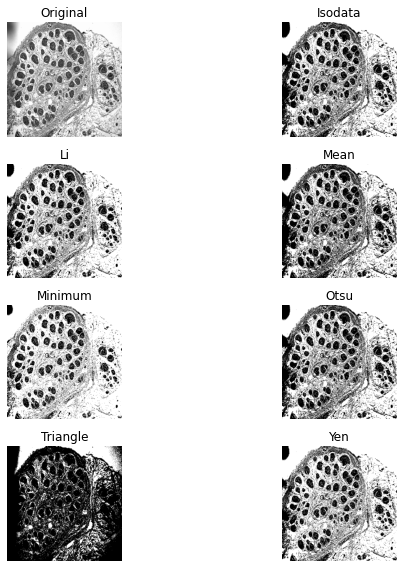

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


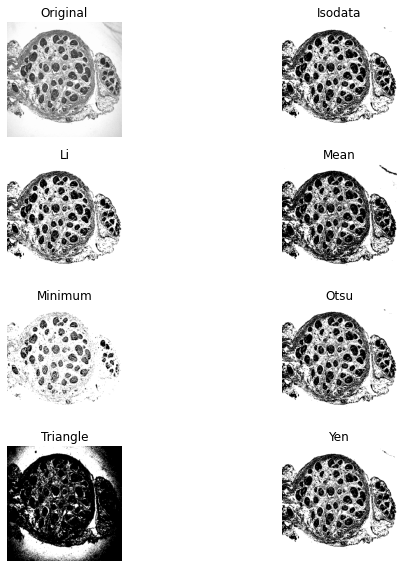

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


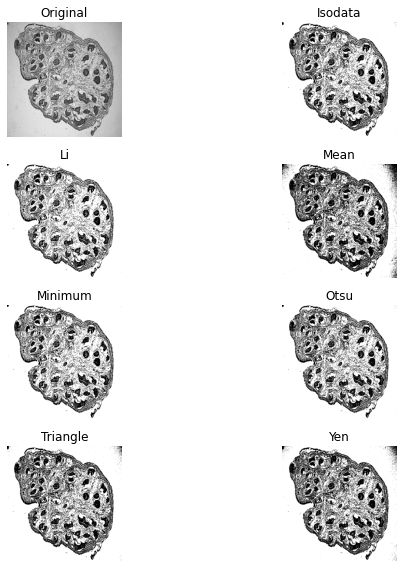

In [18]:
from skimage.filters import try_all_threshold

for fname in fnames_masks:
    imgpath = os.path.join(os.getcwd(), img_folder, fname)
    img = np.load(imgpath)
    img_bg = np.dot(img[..., :3], [0.299, 0.587, 0.114])
    fig, ax = try_all_threshold(img_bg, figsize=(10, 8), verbose=True)
    plt.show()

In [34]:
def watershed(mask):
    thresh = ((1 - mask) * 255).astype('uint8')
    img = cv2.merge((thresh,thresh,thresh))
    
    fig, axs = plt.subplots(1,2, figsize=(12, 12))

    fig_steps, axs_steps = plt.subplots(2,4, figsize=(12, 12))

    axs[0].imshow(thresh, cmap = 'gray')
    axs[0].set_title('Original mask')
    axs_steps[0,0].imshow(thresh, cmap = 'gray')
    axs_steps[0,0].set_title('Original mask')

    # Morhphological operations to remove noise - morphological opening
    # To remove holes we can use closing, but this is not our case (or at least I think...)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    
    axs_steps[0,1].imshow(opening, cmap = 'gray')
    axs_steps[0,1].set_title('Morphological opening')

    # We find what we are sure is background
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    axs_steps[0,2].imshow(sure_bg, cmap = 'gray')
    axs_steps[0,2].set_title('Sure background')


    #Finding sure foreground area using distance transform and thresholding
    # intensities of the points inside the foreground regions are changed to 
    # distance their respective distances from the closest 0 value (boundary). 
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    # Thresholding the dist transform by starting at coeff times its max value
    # Tried different values of coeff, 0.4 seems the best one in order not to erode too much
    coeff = 0.35
    ret, sure_fg = cv2.threshold(dist_transform, coeff*dist_transform.max(),255,0)
    
    ret1, sure_fg1 = cv2.threshold(dist_transform, 0.1*dist_transform.max(),255,0)

    axs_steps[0,3].imshow(sure_fg, cmap = 'gray')
    axs_steps[0,3].set_title('Sure foreground\nThresholded the distance transform\nat 0.35*maximum value')

    # Finding unknown region, the one that is not sure background and not sure foregound
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    sure_fg1 = np.uint8(sure_fg1)
    unknown1 = cv2.subtract(sure_bg,sure_fg1)
    
    axs_steps[1,0].imshow(unknown, cmap = 'gray')
    axs_steps[1,0].set_title('Unknown region')

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    
    ret1, markers1 =  cv2.connectedComponents(sure_fg1)

    axs_steps[1,1].imshow(markers, cmap = 'gray')
    axs_steps[1,1].set_title('Markers')
    
    # Add 10 to all labels so that sure background is not 0, but 10
    markers = markers + 10

    markers1 = markers1 + 10
    
    # Mark the region of unknown with zero
    markers[unknown==255] = 0
    axs_steps[1,2].imshow(markers, cmap = 'gray')
    axs_steps[1,2].set_title('Markers and unknown region')

    markers1[unknown1==255] = 0
    # Using watershed to have the markers
    markers = cv2.watershed(img,markers)
    
    markers1 = cv2.watershed(img,markers1)
    
    # We draw a red border according to the markers
    img[markers == -1] = [255,0,0]
    
    # We draw a red border according to the markers1
    img[markers1 == -1] = [255,0,0]
    
    axs[1].imshow(img)
    axs[1].set_title('Final result\nafter watershed')
    fig.show()

    axs_steps[1,3].imshow(img)
    axs_steps[1,3].set_title('Final result\nafter watershed')
    fig_steps.show()

In [32]:
trained_model_checkpoint = os.path.join(os.getcwd(), 'model_checkpoints/transforms512.h5')
trained_model = keras.models.load_model(trained_model_checkpoint)

<ipython-input-34-e29b7ccbdce7>:85: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-34-e29b7ccbdce7>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_steps.show()


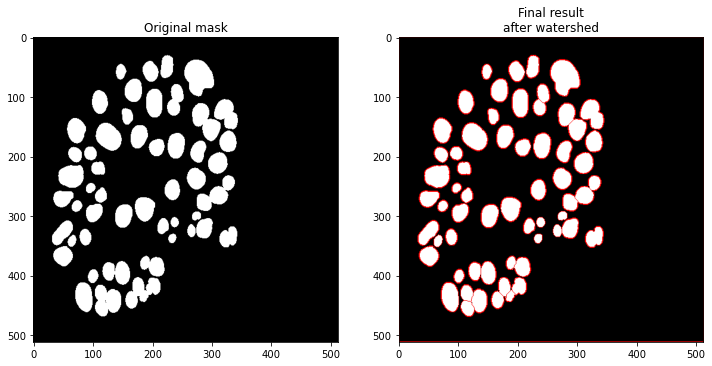

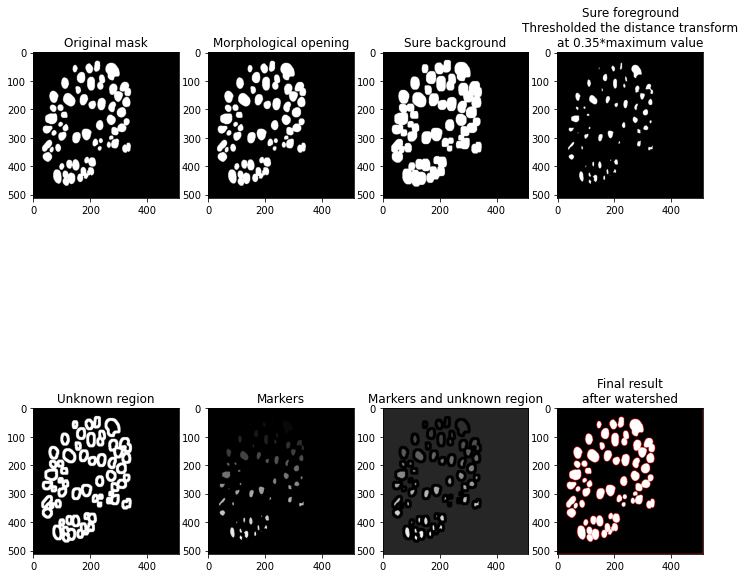

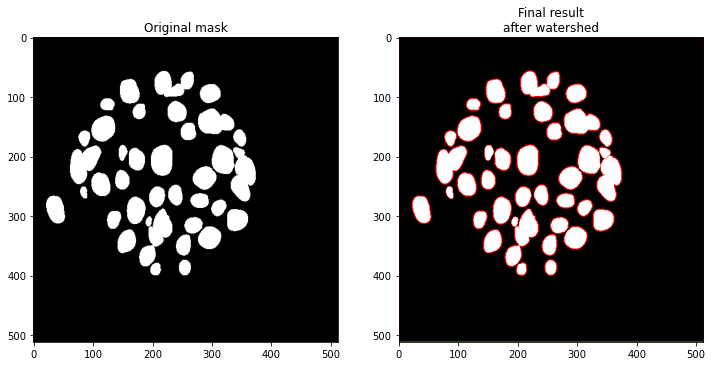

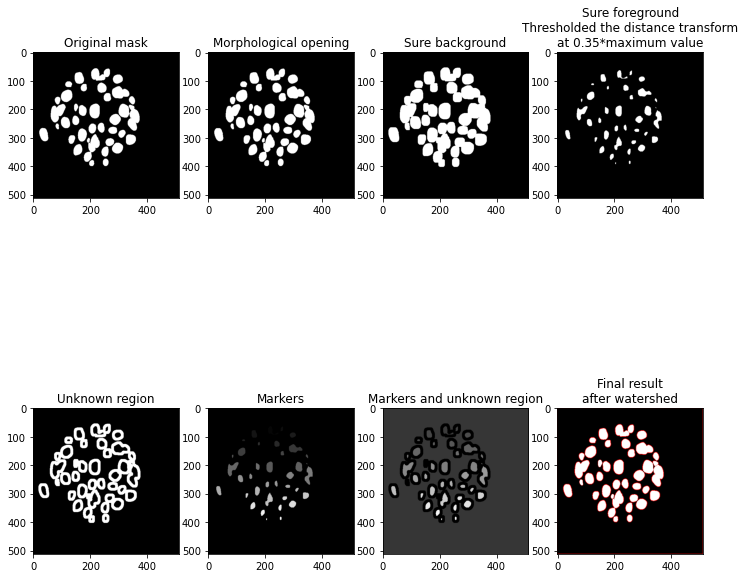

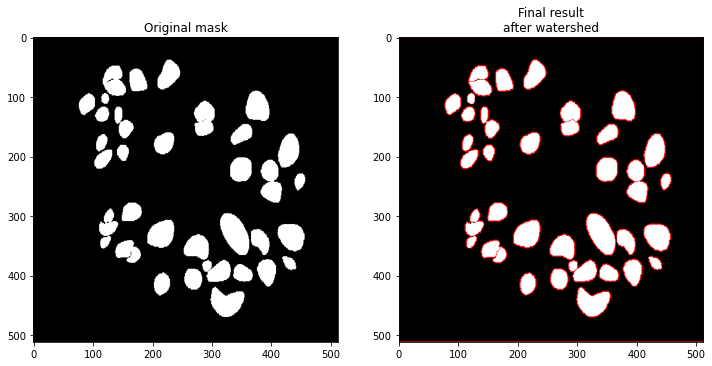

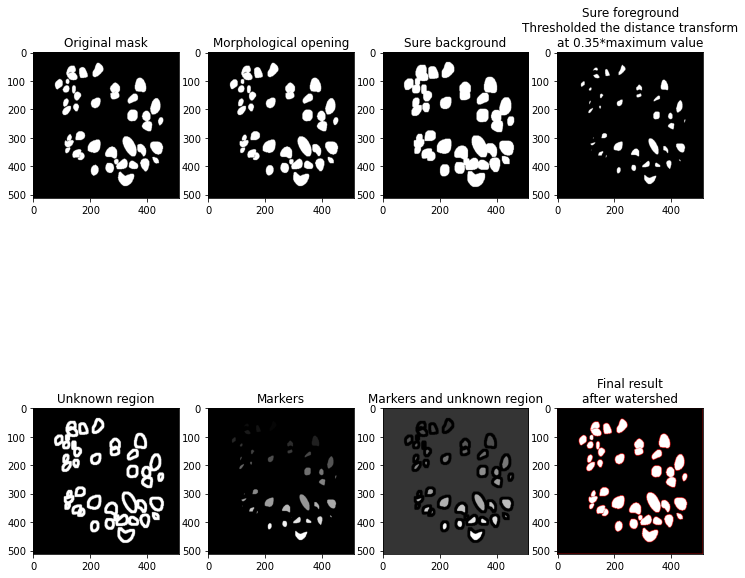

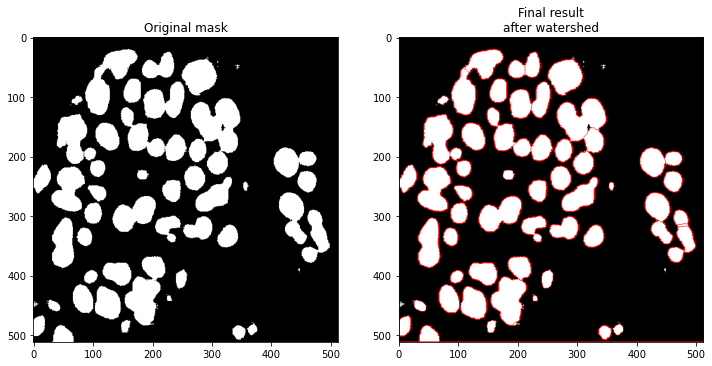

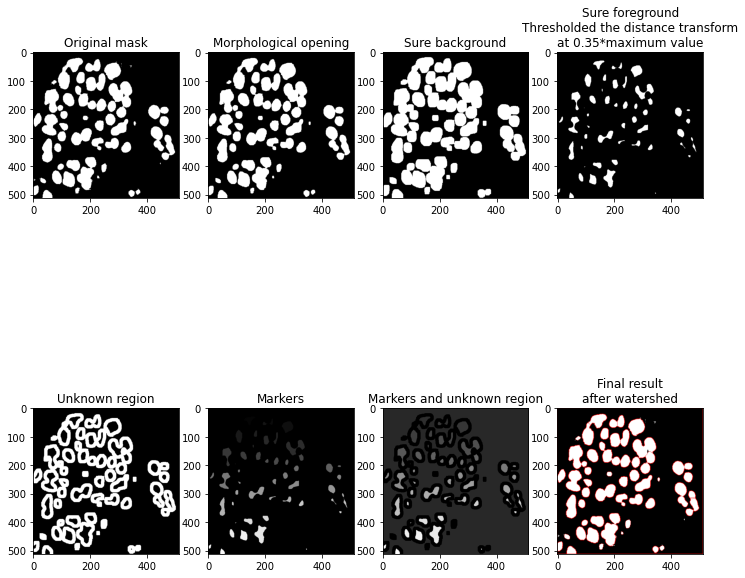

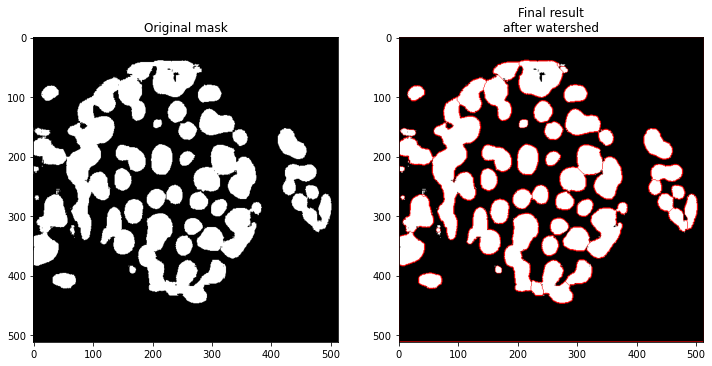

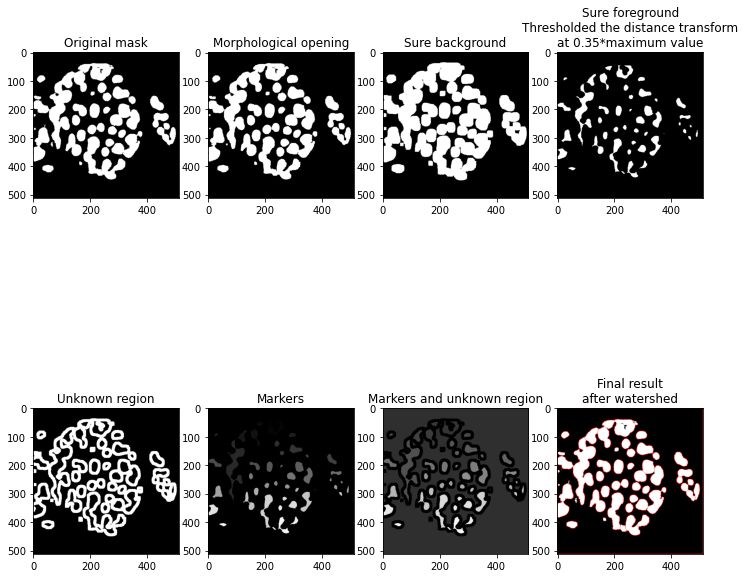

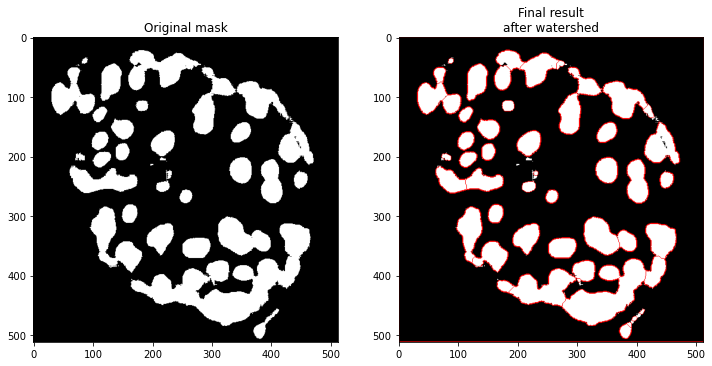

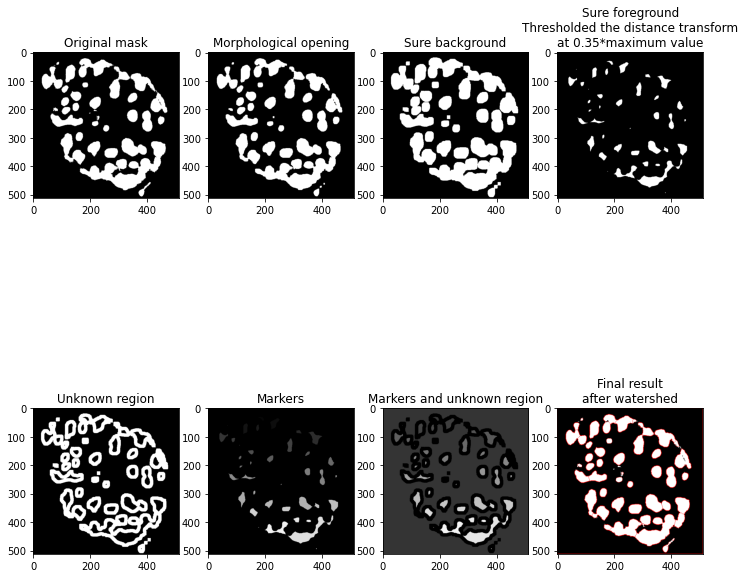

In [35]:
import cv2

# https://www.youtube.com/watch?v=lOZDTDOlqfk

for fname in fnames_masks:
    maskpath = os.path.join(os.getcwd(), mask_folder, fname)
    mask = np.load(maskpath)
    watershed(mask)

for fname in fnames_masks:
    imgpath = os.path.join(os.getcwd(), img_folder, fname)
    img = np.load(imgpath)
    pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]
    watershed(pred)




## RegionProps 

In [2]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import cv2

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

(1917, 2556, 3)
(1917, 2556)
[  0 255]
<class 'numpy.ndarray'>


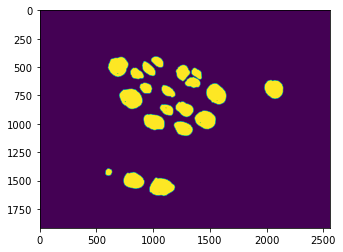

In [182]:
#image = cv2.imread("../data/train/masks_old/vago DX  - 27.06.18 - HH - vetrino 1 - centrale - campione 0010.jpg")
image = cv2.imread("data/mask/00005.mask.tif")
#image = cv2.imread("data/mask/augmented_mask_1_627966.jpg")
print(image.shape)
(thresh, image) = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
print(image.shape)
print(np.unique(image))
print(type(image))

label_img = label(image)
regions = regionprops(label_img)
plt.imshow(image)

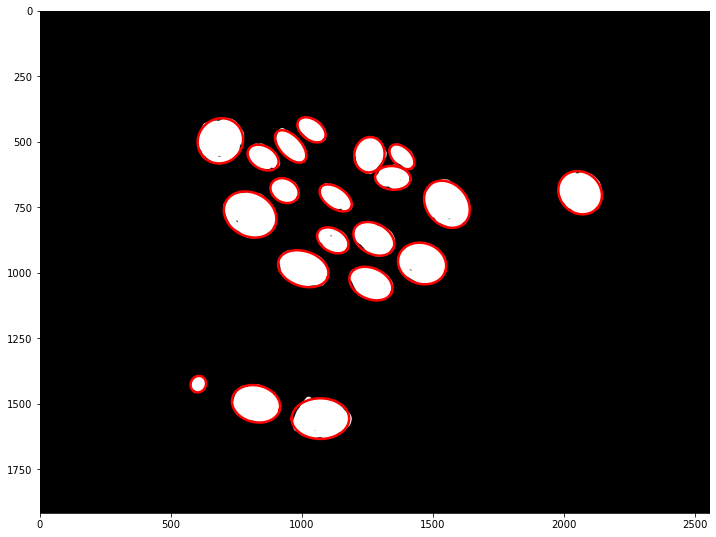

In [183]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = math.pi /2 - props.orientation
    moments = props.moments_central
    theta = np.linspace(0, 2*math.pi, 100)
    x = x0 + 0.5 * props.major_axis_length * math.cos(orientation) * np.cos(theta) - 0.5 * props.minor_axis_length * math.sin(orientation) * np.sin(theta) 
    y = y0 + 0.5 * props.major_axis_length * math.sin(orientation) * np.cos(theta) + 0.5 * props.minor_axis_length * math.cos(orientation) * np.sin(theta)
    ax.plot(x, y, '-r', linewidth=2.5)

plt.show()